# Row source generator

# SQL Tuning principles & strategies

- SQL Tuning Principles
    - identifying the issue
    - clarify the details of the issue
    - cllecting data
    - analyze the data
    - choose an appropriate tuning strategy
  
- SQL Tuning Strategies
    - Parse time reduction
    - Plan comparison strategy
    - Quicl solution strategy
    - Finding & implementing a good plan
    - Query analysis Strategy

# Query Analysis Strategy

- Query can be modified
- Determine the underlying cause

- What to do on this strategy
    - Statistics and Parameters
        - recent?
    - Query Structure
    - Access Paths
    - Join orders & join methods
    - others

- collecting data
    - execution plan
    - information of objects in the query
    - statistics
        - object statistics
        - system statistics
    - histograms
    - parameter settings
        - SQLT
        - DBMS_STATS
        - TKPROF
        - AWR Report
       
- Pre analyze of the query
    - check the volume of resulting data
    - check the predicates
    - Check the problematic constructs
    
- Analyzing the execution plan
    - tools to get the execution plan
        - SQL Trace
        - TKPROF
        - V$\_SQL\_PLAN
        - DBMS\_MONITOR
        - AWRSQRPT.SQL
    - how to read the execution plan
        - check the access paths
        - check the join order and the join type
        - compare actual & estimated number of rows
        - find the steps where cost and logical reads are different significantly
       
       
- Analyzing by considering the query tuning technique
- Find a possible solution
    - Updating statistics
    - Using dynamic statistics
    - Creating or re-creating an index
    - Creating index-organized tables
    - Using hints
    - Others

# Execution plan & statistics

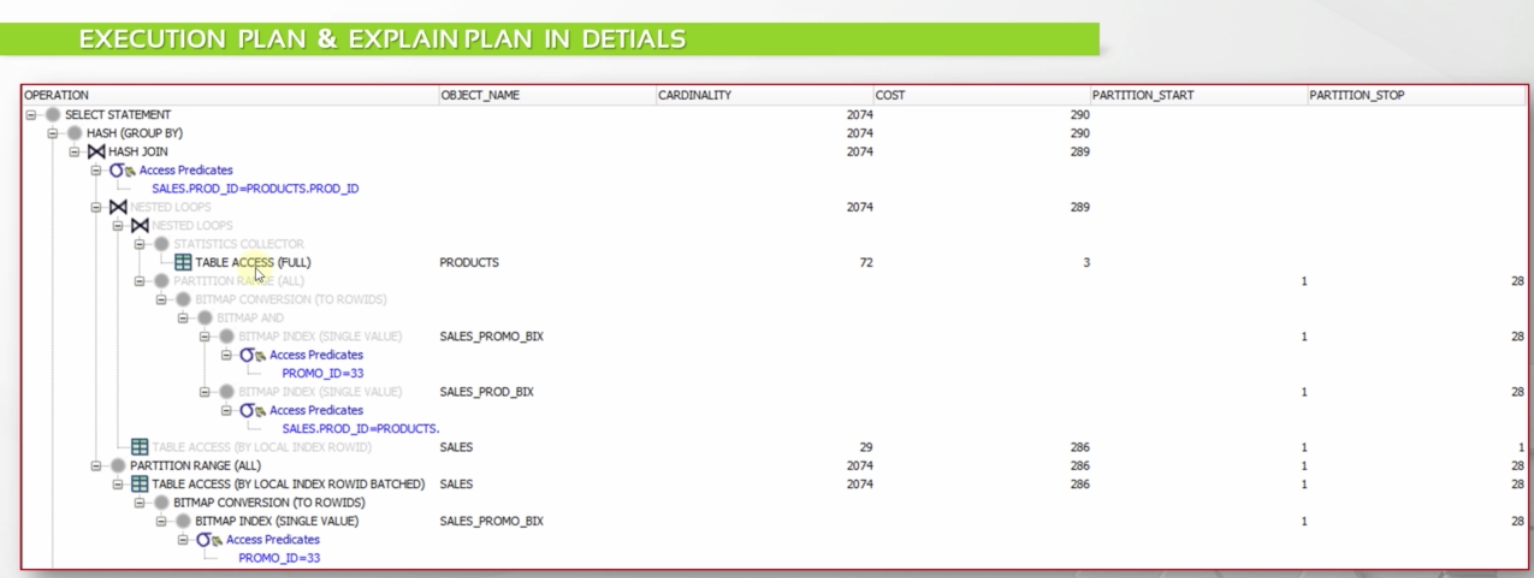

- Because the explain plan was created based on the estimates, but the actual explain plan is modified while the execution based on the real execution
- after the execution, it writes that execution plan to the shared SQL area in the library cache

- operation : plan
- object_name : raw source
- cardinality : how many rows
- partition_start
- partition_stop 

# Generating Statistics

- Statistics types
    - System
    - Optimizer
    
- System Statistics
    - used by the optimizer to estimate I/O and CPU costs
    - should be generated regularly
    - should be gathered during a normal workload
    
```sql
EXEC dbms_stats.gather_system_stats('Start');
SELECT * FROM sys.aux_stats$;
```


- Optimizer Statistics
    - Can be gathered manually or automatially
    - postponed when there's a high workload
    
```sql
ANALYZE TABLE <table_name> COMPUTE STATISTICS;

-- more exact using dbms_stats
``` 
    - GATHER_DATABASE_STATS procedure : check oracle docs for  real use
        - it does not generate the statistics about your system, this one generates the statistics of the users like HR, SF, etc, not on work hour

    - GATHER_DISTIONARY_STATS Procedure : not on work hour
    
```sql
EXEC dbms_stats.gather_dictionary_stats;
```

    - GATHER_SCHEMA_STATS procedure
```sql
EXEC dbms_stats.gather_schema_stats(ownname => 'SH');
```
    - GATHER_TABLE_STATS procedure
        - cascade true : stats on all the indexes on the table, too
    
```sql
EXEC dbms_stats.gather_table_stats(ownname => 'SH', tabname=>'SALES', cascade=>true);
``` 

    - GATHER_INDEX_STATS procedure

- How can we see the optimizer statistics?
    - DBA_TABLES
    - DBA_TAB_STATISTICS
    - DBA_TAB_COL_STATISTICS
    - DBA_INDEXES
    - DBA_CLUSTERS
    - DBA_TAB_PARTITIONS
    - DBA_IND_PARTITIONS
    - DBA_PART_COL_STATISTICS

# Generating Execution Plans

- To analyze an execution plan
    - Explain plan
    - Autotrace
    - V$SQL_PLAN
    
- EXPLAIN PLAN
```sql
EXPLAIN PLAN FOR <QUERY>;
``` 
    - Generates the explain plan and saves into plan_table
    
```sql
SELECT * FROM TABLE(dbms_xplan.display());
``` 

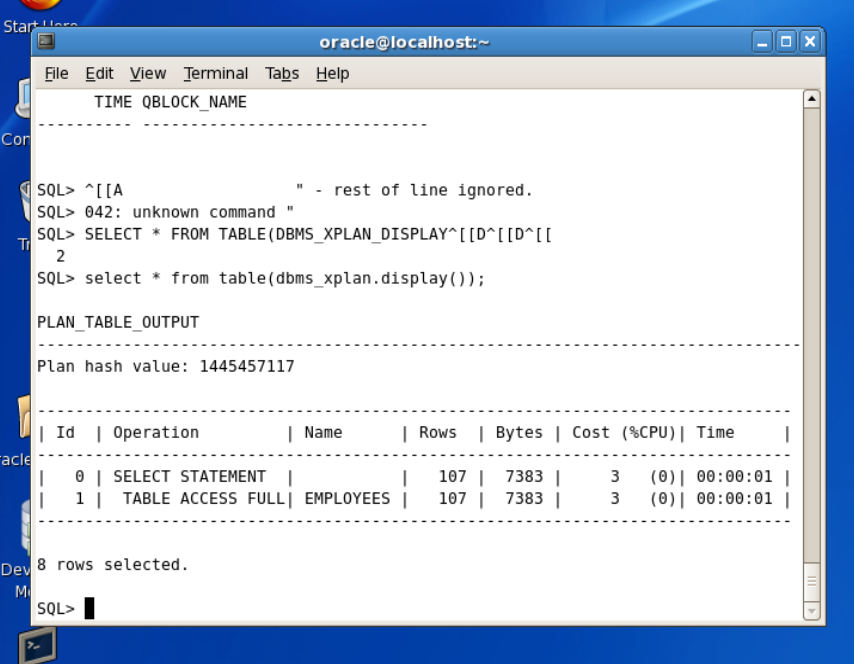

```sql
EXPLAIN PLAN SET statement_id = 'MyID' INTO MyPlanTable FOR SELECT * FROM employees WHERE employee_id = 100;
```

# Autotrace

- Autotrace traces our query and produces the execution plan and the statistics
```sql
SET AUTOTRACE ON;
SET AUTOTRACE ON [EXPLAIN|STATISTICS];
SET AUTOTRACE TRACE[ONLY] ON [EXPLAIN|STATISTICS];
SET AUTOTRACE OFF;
```
- Autotrace uses plan_table like the explain plan


# V$SQL_PLAN VIEW

```
- Dynamic performance view
    - V$SQLAREA
    - V$SQL_WORKAREA
    - V$SQL
    - V$SQL_PLAN
    - V$SQL_PLAN_STATISTICS
    - V$SQL_PLAN_STATISTICS_ALL
    
- V$SQL_PLAN
    - actual execution plans are stored here
    - it is very similar to plan_table 
    it is connected to V$SQL view
```    
```sql
SELECT * FROM TABLE(DBMS_XPLAN.DISPLAY_CURSOR('5d4x'));
```

```sql
SELECT * FROM v$sqlarea;
SELECT * FROM v$sqlstats;
SELECT * FROM v$sql;
SELECT * FROM v$sql_plan;
SELECT * FROM v$sql_workarea;
SELECT * FROM v$sql_plan_statistics;
SELECT * FROM v$sql_plan_statistics_all;
 
 SELECT s.prod_id
  FROM sales s, customers c
  WHERE s.cust_id = c.cust_id;
 
select * from v$sql;
select * from v$sql where sql_text like '%SELECT s.prod_id 
                                           FROM sales s, customers c 
                                           WHERE s.cust_id = c.cust_id%';
select * from v$sql where sql_text like '%SELECT s.prod_id FROM sales s, customers c WHERE s.cust_id = c.cust_id%';
 
 SELECT /* my query */ s.prod_id
  FROM sales s, customers c
  WHERE s.cust_id = c.cust_id;
 
select * from v$sql where sql_text like '%my query%';
select * from v$sql_plan where sql_id = '';
select * from table(dbms_xplan.display_cursor(''));
```                                               

# Reading Execution Plan 1

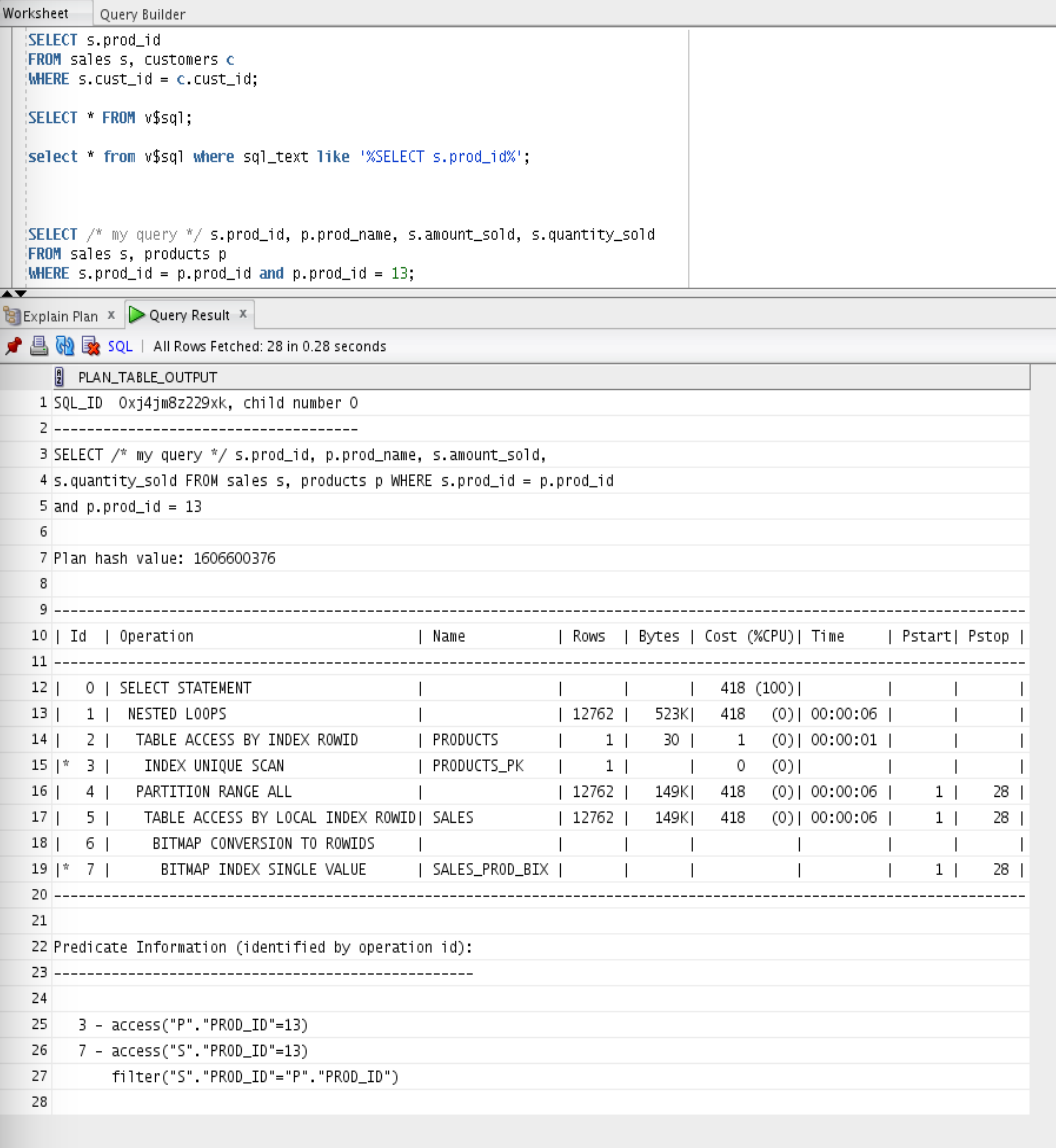

- If it uses an access predicate, it searches this value in the discs or memory. So it reads the rows which have the related access predicate. So access predicates are used on the row sources. 
- But sometimes we read more than we need from the memory or discs. Because the optimizer thinks this is faster.So, once the rows are read, if there is any filter predicate, that predicate is applied to the rows read and the ones which satisfy that condition is returned as the result.
- The reason is, sometimes, reading the whole rows respectively and eliminate the unnecessary ones at the memory will be faster.

- 7 : it gets all the index rows which ahve the prod_id 13 then makes a filter on that. Since we got the prod_ids on the operation id 2, we can easily compare it with the ones we read right now and apply a filter for that. So, we get the ones which are there in the products table and discard the other ones. Then, the server sends that result to the id 6,

# Reading and Anlyzing Execution Plans 2